#Import stuffs

In [ ]:
!pip install pytorch-lightning
!pip install einops
!pip install pykeops
!pip install opt-einsum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 14.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 KB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━

In [ ]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import random
from datetime import datetime as dt

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Module, Parameter

from functools import partial
from scipy import special as ss
from pytorch_lightning.utilities import rank_zero_only
from einops import rearrange, repeat
import opt_einsum as oe
import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
random.seed(67686970)
torch.manual_seed(67686970)

contract = oe.contract
contract_expression = oe.contract_expression

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def read_data():
  # Load CSV into dataframe and format
  df = pd.read_csv('final_daily.csv')
  df['date']=pd.to_datetime(df['date'])
  df=df[df['date']<datetime.datetime(2023,1,1)]

  variable = ['price', 'demand', 'avg_temp']

  scaler = MinMaxScaler()
  df[variable] = scaler.fit_transform(df[variable].values.reshape(-1, len(variable)))

  VAL_PERC = 0.30

  n_train = int(len(df[:-365]) * (1 - VAL_PERC))

  dataframe_train = df[variable][0:n_train]
  train_df = dataframe_train.values.reshape(-1, len(variable))

  dataframe_val = df[variable][n_train:-365]
  val_df = dataframe_val.values.reshape(-1, len(variable))

  dataframe_test = df[variable][-365:]
  test_df = dataframe_test.values.reshape(-1, len(variable))

  dataframe_dataset = df[variable][0:df.shape[0]]
  dataset= dataframe_dataset.values.reshape(-1, len(variable))

  return df, train_df, val_df, test_df, dataset, scaler

In [ ]:
def to_sequences(dataset, seq_size): # seq_size is Number of time steps to look back 
                                       #Larger sequences (look further back) may improve forecasting.
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), :]
        x.append(window)
        y.append(dataset[i+seq_size, :])
    print(np.array(x).shape)
        
    return np.array(x),np.array(y)

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

#S4 setups

In [ ]:
import pykeops
from pykeops.torch import Genred
has_pykeops = True
def cauchy_conj(v, z, w):
    """ Pykeops version """
    expr_num = 'z * ComplexReal(v) - Real2Complex(Sum(v * w))'
    expr_denom = 'ComplexMult(z-w, z-Conj(w))'

    cauchy_mult = Genred(
        f'ComplexDivide({expr_num}, {expr_denom})',
        # expr_num,
        # expr_denom,
        [
            'v = Vj(2)',
            'z = Vi(2)',
            'w = Vj(2)',
        ],
        reduction_op='Sum',
        axis=1,
    )

    v, z, w = _broadcast_dims(v, z, w)
    v = _c2r(v)
    z = _c2r(z)
    w = _c2r(w)

    r = 2*cauchy_mult(v, z, w)
    return _r2c(r)

def _broadcast_dims(*tensors):
    max_dim = max([len(tensor.shape) for tensor in tensors])
    tensors = [tensor.view((1,)*(max_dim-len(tensor.shape))+tensor.shape) for tensor in tensors]
    return tensors

_c2r = torch.view_as_real
_r2c = torch.view_as_complex
_conj = lambda x: torch.cat([x, x.conj()], dim=-1)
if tuple(map(int, torch.__version__.split('.')[:2])) >= (1, 10):
    _resolve_conj = lambda x: x.conj().resolve_conj()
else:
    _resolve_conj = lambda x: x.conj()

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [ ]:
class TransposedLinear(nn.Module):
    """ Linear module on the second-to-last dimension """

    def __init__(self, d_input, d_output, bias=True):
        super().__init__()

        self.weight = nn.Parameter(torch.empty(d_output, d_input))
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5)) # nn.Linear default init
        # nn.init.kaiming_uniform_(self.weight, nonlinearity='linear') # should be equivalent

        if bias:
            self.bias = nn.Parameter(torch.empty(d_output, 1))
            bound = 1 / math.sqrt(d_input)
            nn.init.uniform_(self.bias, -bound, bound)
        else:
            self.bias = 0.0

    def forward(self, x):
        return contract('... u l, v u -> ... v l', x, self.weight) + self.bias

In [ ]:
def LinearActivation(
        d_input, d_output, bias=True,
        zero_bias_init=False,
        transposed=False,
        weight_norm=False,
        **kwargs,
    ):
    """ Returns a linear nn.Module with control over axes order, initialization, and activation """

    # Construct core module
    linear_cls = TransposedLinear if transposed else nn.Linear
    #if activation == 'glu': d_output *= 2
    linear = linear_cls(d_input, d_output, bias=bias)

    # Initialize weight
    nn.init.kaiming_uniform_(linear.weight)

    # Initialize bias
    if bias and zero_bias_init:
        nn.init.zeros_(linear.bias)

    # Weight norm
    if weight_norm:
        linear = nn.utils.weight_norm(linear)

    activation = nn.ReLU()
    linear = nn.Sequential(linear, activation)
    return linear

In [ ]:
""" Misc functional utilities """

def krylov(L, A, b, c=None, return_power=False):
    """
    Compute the Krylov matrix (b, Ab, A^2b, ...) using the squaring trick.
    If return_power=True, return A^{L-1} as well
    """
    # TODO There is an edge case if L=1 where output doesn't get broadcasted, which might be an issue if caller is expecting broadcasting semantics... can deal with it if it arises

    x = b.unsqueeze(-1) # (..., N, 1)
    A_ = A

    AL = None
    if return_power:
        AL = torch.eye(A.shape[-1], dtype=A.dtype, device=A.device)
        _L = L-1

    done = L == 1
    # loop invariant: _L represents how many indices left to compute
    while not done:
        if return_power:
            if _L % 2 == 1: AL = A_ @ AL
            _L //= 2

        # Save memory on last iteration
        l = x.shape[-1]
        if L - l <= l:
            done = True
            _x = x[..., :L-l]
        else: _x = x

        _x = A_ @ _x
        x = torch.cat([x, _x], dim=-1) # there might be a more efficient way of ordering axes
        if not done: A_ = A_ @ A_

    assert x.shape[-1] == L

    if c is not None:
        x = torch.einsum('...nl, ...n -> ...l', x, c)
    x = x.contiguous() # WOW!!
    if return_power:
        return x, AL
    else:
        return x

In [ ]:
def power(L, A, v=None):
    """ Compute A^L and the scan sum_i A^i v_i
    A: (..., N, N)
    v: (..., N, L)
    """

    I = torch.eye(A.shape[-1]).to(A) # , dtype=A.dtype, device=A.device)

    powers = [A]
    l = 1
    while True:
        if L % 2 == 1: I = powers[-1] @ I
        L //= 2
        if L == 0: break
        l *= 2
        powers.append(powers[-1] @ powers[-1])

    if v is None: return I

    # Invariants:
    # powers[-1] := A^l
    # l := largest po2 at most L

    # Note that an alternative divide and conquer to compute the reduction is possible and can be embedded into the above loop without caching intermediate powers of A
    # We do this reverse divide-and-conquer for efficiency reasons:
    # 1) it involves fewer padding steps for non-po2 L
    # 2) it involves more contiguous arrays

    # Take care of edge case for non-po2 arrays
    # Note that this initial step is a no-op for the case of power of 2 (l == L)
    k = v.size(-1) - l
    v_ = powers.pop() @ v[..., l:]
    v = v[..., :l]
    v[..., :k] = v[..., :k] + v_

    # Handle reduction for power of 2
    while v.size(-1) > 1:
        v = rearrange(v, '... (z l) -> ... z l', z=2)
        v = v[..., 0, :] + powers.pop() @ v[..., 1, :]
    return I, v.squeeze(-1)

In [ ]:
""" HiPPO utilities """

def embed_c2r(A):
    A = rearrange(A, '... m n -> ... m () n ()')
    A = np.pad(A, ((0, 0), (0, 1), (0, 0), (0, 1))) + \
        np.pad(A, ((0, 0), (1, 0), (0, 0), (1,0)))
    return rearrange(A, 'm x n y -> (m x) (n y)')

In [ ]:
def transition(measure, N, **measure_args):
    """ A, B transition matrices for different measures
    measure: the type of measure
      legt - Legendre (translated)
      legs - Legendre (scaled)
      glagt - generalized Laguerre (translated)
      lagt, tlagt - previous versions of (tilted) Laguerre with slightly different normalization
    """
    # Laguerre (translated)
    if measure == 'lagt':
        b = measure_args.get('beta', 1.0)
        A = np.eye(N) / 2 - np.tril(np.ones((N, N)))
        B = b * np.ones((N, 1))
    # Generalized Laguerre
    # alpha 0, beta small is most stable (limits to the 'lagt' measure)
    # alpha 0, beta 1 has transition matrix A = [lower triangular 1]
    elif measure == 'glagt':
        alpha = measure_args.get('alpha', 0.0)
        beta = measure_args.get('beta', 0.01)
        A = -np.eye(N) * (1 + beta) / 2 - np.tril(np.ones((N, N)), -1)
        B = ss.binom(alpha + np.arange(N), np.arange(N))[:, None]

        L = np.exp(.5 * (ss.gammaln(np.arange(N)+alpha+1) - ss.gammaln(np.arange(N)+1)))
        A = (1./L[:, None]) * A * L[None, :]
        B = (1./L[:, None]) * B * np.exp(-.5 * ss.gammaln(1-alpha)) * beta**((1-alpha)/2)
    # Legendre (translated)
    elif measure == 'legt':
        Q = np.arange(N, dtype=np.float64)
        R = (2*Q + 1) ** .5
        j, i = np.meshgrid(Q, Q)
        A = R[:, None] * np.where(i < j, (-1.)**(i-j), 1) * R[None, :]
        B = R[:, None]
        A = -A
    # Legendre (scaled)
    elif measure == 'legs':
        q = np.arange(N, dtype=np.float64)
        col, row = np.meshgrid(q, q)
        r = 2 * q + 1
        M = -(np.where(row >= col, r, 0) - np.diag(q))
        T = np.sqrt(np.diag(2 * q + 1))
        A = T @ M @ np.linalg.inv(T)
        B = np.diag(T)[:, None]
        B = B.copy() # Otherwise "UserWarning: given NumPY array is not writeable..." after torch.as_tensor(B)
    elif measure == 'fourier':
        freqs = np.arange(N//2)
        d = np.stack([freqs, np.zeros(N//2)], axis=-1).reshape(-1)[:-1]
        A = 2*np.pi*(np.diag(d, 1) - np.diag(d, -1))
        A = A - embed_c2r(np.ones((N//2, N//2)))
        B = embed_c2r(np.ones((N//2, 1)))[..., :1]
    elif measure == 'random':
        A = np.random.randn(N, N) / N
        B = np.random.randn(N, 1)
    elif measure == 'diagonal':
        A = -np.diag(np.exp(np.random.randn(N)))
        B = np.random.randn(N, 1)
    else:
        raise NotImplementedError

    return A, B

In [ ]:
def rank_correction(measure, N, rank=1, dtype=torch.float):
    """ Return low-rank matrix L such that A + L is normal """

    if measure == 'legs':
        assert rank >= 1
        P = torch.sqrt(.5+torch.arange(N, dtype=dtype)).unsqueeze(0) # (1 N)
    elif measure == 'legt':
        assert rank >= 2
        P = torch.sqrt(1+2*torch.arange(N, dtype=dtype)) # (N)
        P0 = P.clone()
        P0[0::2] = 0.
        P1 = P.clone()
        P1[1::2] = 0.
        P = torch.stack([P0, P1], dim=0) # (2 N)
    elif measure == 'lagt':
        assert rank >= 1
        P = .5**.5 * torch.ones(1, N, dtype=dtype)
    elif measure == 'fourier':
        P = torch.ones(N, dtype=dtype) # (N)
        P0 = P.clone()
        P0[0::2] = 0.
        P1 = P.clone()
        P1[1::2] = 0.
        P = torch.stack([P0, P1], dim=0) # (2 N)
    else: raise NotImplementedError

    d = P.size(0)
    if rank > d:
        P = torch.cat([P, torch.zeros(rank-d, N, dtype=dtype)], dim=0) # (rank N)
    return P

In [ ]:
def nplr(measure, N, rank=1, dtype=torch.float):
    """ Return w, p, q, V, B such that
    (w - p q^*, B) is unitarily equivalent to the original HiPPO A, B by the matrix V
    i.e. A = V[w - p q^*]V^*, B = V B
    """
    assert dtype == torch.float or torch.cfloat
    if measure == 'random':
        dtype = torch.cfloat if dtype == torch.float else torch.cdouble
        # w = torch.randn(N//2, dtype=dtype)
        w = -torch.exp(torch.randn(N//2)) + 1j*torch.randn(N//2)
        P = torch.randn(rank, N//2, dtype=dtype)
        B = torch.randn(N//2, dtype=dtype)
        V = torch.eye(N, dtype=dtype)[..., :N//2] # Only used in testing
        return w, P, B, V

    A, B = transition(measure, N)
    A = torch.as_tensor(A, dtype=dtype) # (N, N)
    B = torch.as_tensor(B, dtype=dtype)[:, 0] # (N,)

    P = rank_correction(measure, N, rank=rank, dtype=dtype)
    AP = A + torch.sum(P.unsqueeze(-2)*P.unsqueeze(-1), dim=-3)
    w, V = torch.linalg.eig(AP) # (..., N) (..., N, N)
    # V w V^{-1} = A

    # Only keep one of the conjugate pairs
    w = w[..., 0::2].contiguous()
    V = V[..., 0::2].contiguous()

    V_inv = V.conj().transpose(-1, -2)

    B = contract('ij, j -> i', V_inv, B.to(V)) # V^* B
    P = contract('ij, ...j -> ...i', V_inv, P.to(V)) # V^* P


    return w, P, B, V

In [ ]:
def bilinear(dt, A, B=None):
    """
    dt: (...) timescales
    A: (... N N)
    B: (... N)
    """
    N = A.shape[-1]
    I = torch.eye(N).to(A)
    A_backwards = I - dt[:, None, None] / 2 * A
    A_forwards = I + dt[:, None, None] / 2 * A

    if B is None:
        dB = None
    else:
        dB = dt[..., None] * torch.linalg.solve(
            A_backwards, B.unsqueeze(-1)
        ).squeeze(-1) # (... N)

    dA = torch.linalg.solve(A_backwards, A_forwards)  # (... N N)
    return dA, dB

In [ ]:
class SSKernelNPLR(nn.Module):
    """Stores a representation of and computes the SSKernel function K_L(A^dt, B^dt, C) corresponding to a discretized state space, where A is Normal + Low Rank (NPLR)
    The class name stands for 'State-Space SSKernel for Normal Plus Low-Rank'.
    The parameters of this function are as follows.
    A: (... N N) the state matrix
    B: (... N) input matrix
    C: (... N) output matrix
    dt: (...) timescales / discretization step size
    p, q: (... P N) low-rank correction to A, such that Ap=A+pq^T is a normal matrix
    The forward pass of this Module returns:
    (... L) that represents represents FFT SSKernel_L(A^dt, B^dt, C)
    """

    @torch.no_grad()
    def _setup_C(self, double_length=False):
        """ Construct C~ from C
        double_length: current C is for length L, convert it to length 2L
        """
        C = _r2c(self.C)
        self._setup_state()
        dA_L = power(self.L, self.dA)
        # Multiply C by I - dA_L
        C_ = _conj(C)
        prod = contract("h m n, c h n -> c h m", dA_L.transpose(-1, -2), C_)
        if double_length: prod = -prod # Multiply by I + dA_L instead
        C_ = C_ - prod
        C_ = C_[..., :self.N] # Take conjugate pairs again
        self.C.copy_(_c2r(C_))

        if double_length:
            self.L *= 2
            self._omega(self.L, dtype=C.dtype, device=C.device, cache=True)

    def _omega(self, L, dtype, device, cache=True):
        """ Calculate (and cache) FFT nodes and their "unprocessed" them with the bilinear transform
        This should be called everytime the internal length self.L changes """
        omega = torch.tensor(
            np.exp(-2j * np.pi / (L)), dtype=dtype, device=device
        )  # \omega_{2L}
        omega = omega ** torch.arange(0, L // 2 + 1, device=device)
        z = 2 * (1 - omega) / (1 + omega)
        if cache:
            self.register_buffer("omega", _c2r(omega))
            self.register_buffer("z", _c2r(z))
        return omega, z

    def __init__(
        self,
        L, w, P, B, C, log_dt,
        hurwitz=False,
        trainable=None,
        lr=None,
        tie_state=False,
        length_correction=True,
        verbose=False,
    ):
        """
        L: Maximum length; this module computes an SSM kernel of length L
        w: (N)
        p: (r, N) low-rank correction to A
        q: (r, N)
        A represented by diag(w) - pq^*
        B: (N)
        dt: (H) timescale per feature
        C: (H, C, N) system is 1-D to c-D (channels)
        hurwitz: tie pq and ensure w has negative real part
        trainable: toggle which of the parameters is trainable
        lr: add hook to set lr of hippo parameters specially (everything besides C)
        tie_state: tie all state parameters across the H hidden features
        length_correction: multiply C by (I - dA^L) - can be turned off when L is large for slight speedup at initialization (only relevant when N large as well)
        Note: tensor shape N here denotes half the true state size, because of conjugate symmetry
        """

        super().__init__()
        self.hurwitz = hurwitz
        self.tie_state = tie_state
        self.verbose = verbose

        # Rank of low-rank correction
        self.rank = P.shape[-2]
        assert w.size(-1) == P.size(-1) == B.size(-1) == C.size(-1)
        self.H = log_dt.size(-1)
        self.N = w.size(-1)

        # Broadcast everything to correct shapes
        C = C.expand(torch.broadcast_shapes(C.shape, (1, self.H, self.N))) # (H, C, N)
        H = 1 if self.tie_state else self.H
        B = repeat(B, 'n -> 1 h n', h=H)
        P = repeat(P, 'r n -> r h n', h=H)
        w = repeat(w, 'n -> h n', h=H)

        # Cache Fourier nodes every time we set up a desired length
        self.L = L
        if self.L is not None:
            self._omega(self.L, dtype=C.dtype, device=C.device, cache=True)

        # Register parameters
        # C is a regular parameter, not state
        # self.C = nn.Parameter(_c2r(C.conj().resolve_conj()))
        self.C = nn.Parameter(_c2r(_resolve_conj(C)))
        train = False
        if trainable is None: trainable = {}
        if trainable == False: trainable = {}
        if trainable == True: trainable, train = {}, True
        self.register("log_dt", log_dt, trainable.get('dt', train), lr, 0.0)
        self.register("B", _c2r(B), trainable.get('B', train), lr, 0.0)
        self.register("P", _c2r(P), trainable.get('P', train), lr, 0.0)
        if self.hurwitz:
            log_w_real = torch.log(-w.real + 1e-3) # Some of the HiPPO methods have real part 0
            w_imag = w.imag
            self.register("log_w_real", log_w_real, trainable.get('A', 0), lr, 0.0)
            self.register("w_imag", w_imag, trainable.get('A', train), lr, 0.0)
            self.Q = None
        else:
            self.register("w", _c2r(w), trainable.get('A', train), lr, 0.0)
            # self.register("Q", _c2r(P.clone().conj().resolve_conj()), trainable.get('P', train), lr, 0.0)
            Q = _resolve_conj(P.clone())
            self.register("Q", _c2r(Q), trainable.get('P', train), lr, 0.0)

        if length_correction:
            self._setup_C()

    def _w(self):
        # Get the internal w (diagonal) parameter
        if self.hurwitz:
            w_real = -torch.exp(self.log_w_real)
            w_imag = self.w_imag
            w = w_real + 1j * w_imag
        else:
            w = _r2c(self.w)  # (..., N)
        return w

    def forward(self, state=None, rate=1.0, L=None):
        """
        state: (..., s, N) extra tensor that augments B
        rate: sampling rate factor
        returns: (..., c+s, L)
        """
        # Handle sampling rate logic
        # The idea is that this kernel's length (in continuous units) is self.L, while we are asked to provide a kernel of length L at (relative) sampling rate rate
        # If either are not passed in, assume we're not asked to change the scale of our kernel
        assert not (rate is None and L is None)
        if rate is None:
            rate = self.L / L
        if L is None:
            L = int(self.L / rate)

        # Increase the internal length if needed
        while rate * L > self.L:
            self.double_length()

        dt = torch.exp(self.log_dt) * rate
        B = _r2c(self.B)
        C = _r2c(self.C)
        P = _r2c(self.P)
        Q = P.conj() if self.Q is None else _r2c(self.Q)
        w = self._w()

        if rate == 1.0:
            # Use cached FFT nodes
            omega, z = _r2c(self.omega), _r2c(self.z)  # (..., L)
        else:
            omega, z = self._omega(int(self.L/rate), dtype=w.dtype, device=w.device, cache=False)

        if self.tie_state:
            B = repeat(B, '... 1 n -> ... h n', h=self.H)
            P = repeat(P, '... 1 n -> ... h n', h=self.H)
            Q = repeat(Q, '... 1 n -> ... h n', h=self.H)

        # Augment B
        if state is not None:
            # Have to "unbilinear" the state to put it into the same "type" as B
            # Compute 1/dt * (I + dt/2 A) @ state

            # Can do this without expanding (maybe minor speedup using conj symmetry in theory), but it's easier to read this way
            s = _conj(state) if state.size(-1) == self.N else state # (B H N)
            sA = (
                s * _conj(w) # (B H N)
                - contract('bhm, rhm, rhn -> bhn', s, _conj(Q), _conj(P))
            )
            s = s / dt.unsqueeze(-1) + sA / 2
            s = s[..., :self.N]

            B = torch.cat([s, B], dim=-3)  # (s+1, H, N)

        # Incorporate dt into A
        w = w * dt.unsqueeze(-1)  # (H N)

        # Stack B and p, C and q for convenient batching
        B = torch.cat([B, P], dim=-3) # (s+1+r, H, N)
        C = torch.cat([C, Q], dim=-3) # (c+r, H, N)

        # Incorporate B and C batch dimensions
        v = B.unsqueeze(-3) * C.unsqueeze(-4)  # (s+1+r, c+r, H, N)
        # w = w[None, None, ...]  # (1, 1, H, N)
        # z = z[None, None, None, ...]  # (1, 1, 1, L)

        # Calculate resolvent at omega
        r = cauchy_conj(v, z, w)
        r = r * dt[None, None, :, None]  # (S+1+R, C+R, H, L)

        # Low-rank Woodbury correction
        if self.rank == 1:
            k_f = r[:-1, :-1, :, :] - r[:-1, -1:, :, :] * r[-1:, :-1, :, :] / (1 + r[-1:, -1:, :, :])
        elif self.rank == 2:
            r00 = r[: -self.rank, : -self.rank, :, :]
            r01 = r[: -self.rank, -self.rank :, :, :]
            r10 = r[-self.rank :, : -self.rank, :, :]
            r11 = r[-self.rank :, -self.rank :, :, :]
            det = (1 + r11[:1, :1, :, :]) * (1 + r11[1:, 1:, :, :]) - r11[:1, 1:, :, :] * r11[1:, :1, :, :]
            s = (
                r01[:, :1, :, :] * (1 + r11[1:, 1:, :, :]) * r10[:1, :, :, :]
                + r01[:, 1:, :, :] * (1 + r11[:1, :1, :, :]) * r10[1:, :, :, :]
                - r01[:, :1, :, :] * (r11[:1, 1:, :, :]) * r10[1:, :, :, :]
                - r01[:, 1:, :, :] * (r11[1:, :1, :, :]) * r10[:1, :, :, :]
            )
            s = s / det
            k_f = r00 - s
        else:
            r00 = r[:-self.rank, :-self.rank, :, :]
            r01 = r[:-self.rank, -self.rank:, :, :]
            r10 = r[-self.rank:, :-self.rank, :, :]
            r11 = r[-self.rank:, -self.rank:, :, :]
            r11 = rearrange(r11, "a b h n -> h n a b")
            r11 = torch.linalg.inv(torch.eye(self.rank, device=r.device) + r11)
            r11 = rearrange(r11, "h n a b -> a b h n")
            k_f = r00 - torch.einsum("i j h n, j k h n, k l h n -> i l h n", r01, r11, r10)

        # Final correction for the bilinear transform
        k_f = k_f * 2 / (1 + omega)

        # Move from frequency to coefficients
        k = torch.fft.irfft(k_f)  # (S+1, C, H, L)

        # Truncate to target length
        k = k[..., :L]

        if state is not None:
            k_state = k[:-1, :, :, :]  # (S, C, H, L)
        else:
            k_state = None
        k_B = k[-1, :, :, :] # (C H L)
        return k_B, k_state

    @torch.no_grad()
    def double_length(self):
        self._setup_C(double_length=True)

    def _setup_linear(self):
        """ Create parameters that allow fast linear stepping of state """
        w = self._w()
        B = _r2c(self.B) # (H N)
        P = _r2c(self.P)
        Q = P.conj() if self.Q is None else _r2c(self.Q)

        # Prepare Linear stepping
        dt = torch.exp(self.log_dt)
        D = (2.0 / dt.unsqueeze(-1) - w).reciprocal()  # (H, N)
        R = (torch.eye(self.rank, dtype=w.dtype, device=w.device) + 2*contract('r h n, h n, s h n -> h r s', Q, D, P).real) # (H r r)
        Q_D = rearrange(Q*D, 'r h n -> h r n')
        R = torch.linalg.solve(R.to(Q_D), Q_D) # (H r N)
        R = rearrange(R, 'h r n -> r h n')

        self.step_params = {
            "D": D, # (H N)
            "R": R, # (r H N)
            "P": P, # (r H N)
            "Q": Q, # (r H N)
            "B": B, # (1 H N)
            "E": 2.0 / dt.unsqueeze(-1) + w, # (H N)
        }

    def _step_state_linear(self, u=None, state=None):
        """
        Version of the step function that has time O(N) instead of O(N^2) per step, which takes advantage of the DPLR form and bilinear discretization.
        Unfortunately, as currently implemented it's about 2x slower because it calls several sequential operations. Perhaps a fused CUDA kernel implementation would be much faster
        u: (H) input
        state: (H, N/2) state with conjugate pairs
          Optionally, the state can have last dimension N
        Returns: same shape as state
        """
        C = _r2c(self.C) # View used for dtype/device

        if u is None: # Special case used to find dA
            u = torch.zeros(self.H, dtype=C.dtype, device=C.device)
        if state is None: # Special case used to find dB
            state = torch.zeros(self.H, self.N, dtype=C.dtype, device=C.device)

        step_params = self.step_params.copy()
        if state.size(-1) == self.N: # Only store half of the conjugate pairs; should be true by default
            # There should be a slightly faster way using conjugate symmetry
            contract_fn = lambda p, x, y: contract('r h n, r h m, ... h m -> ... h n', _conj(p), _conj(x), _conj(y))[..., :self.N] # inner outer product
        else:
            assert state.size(-1) == 2*self.N
            step_params = {k: _conj(v) for k, v in step_params.items()}
            # TODO worth setting up a contract_expression in default_state if we want to use this at inference time for stepping
            contract_fn = lambda p, x, y: contract('r h n, r h m, ... h m -> ... h n', p, x, y) # inner outer product
        D = step_params["D"]  # (H N)
        E = step_params["E"]  # (H N)
        R = step_params["R"]  # (r H N)
        P = step_params["P"]  # (r H N)
        Q = step_params["Q"]  # (r H N)
        B = step_params["B"]  # (1 H N)

        new_state = E * state - contract_fn(P, Q, state) # (B H N)
        new_state = new_state + 2.0 * B * u.unsqueeze(-1)  # (B H N)
        new_state = D * (new_state - contract_fn(P, R, new_state))

        return new_state

    def _setup_state(self):
        """ Construct dA and dB for discretized state equation """

        # Construct dA and dB by using the stepping
        self._setup_linear()
        C = _r2c(self.C) # Just returns a view that we use for finding dtype/device

        state = torch.eye(2*self.N, dtype=C.dtype, device=C.device).unsqueeze(-2) # (N 1 N)
        dA = self._step_state_linear(state=state)
        dA = rearrange(dA, "n h m -> h m n")
        self.dA = dA # (H N N)

        u = C.new_ones(self.H)
        dB = self._step_state_linear(u=u)
        dB = _conj(dB)
        self.dB = rearrange(dB, '1 h n -> h n') # (H N)

    def _step_state(self, u, state):
        """ Must be called after self.default_state() is used to construct an initial state!  """
        next_state = self.state_contraction(self.dA, state) + self.input_contraction(self.dB, u)
        return next_state


    def setup_step(self, mode='dense'):
        """ Set up dA, dB, dC discretized parameters for stepping """
        self._setup_state()

        # Calculate original C
        dA_L = power(self.L, self.dA)
        I = torch.eye(self.dA.size(-1)).to(dA_L)
        C = _conj(_r2c(self.C)) # (H C N)

        dC = torch.linalg.solve(
            I - dA_L.transpose(-1, -2),
            C.unsqueeze(-1),
        ).squeeze(-1)
        self.dC = dC

        # Do special preprocessing for different step modes

        self._step_mode = mode
        if mode == 'linear':
            # Linear case: special step function for the state, we need to handle output
            # use conjugate symmetry by default, which affects the output projection
            self.dC = 2*self.dC[:, :, :self.N]
        elif mode == 'diagonal':
            # Eigendecomposition of the A matrix
            L, V = torch.linalg.eig(self.dA)
            V_inv = torch.linalg.inv(V)
            # Check that the eigendedecomposition is correct
            if self.verbose:
                print("Diagonalization error:", torch.dist(V @ torch.diag_embed(L) @ V_inv, self.dA))

            # Change the parameterization to diagonalize
            self.dA = L
            self.dB = contract('h n m, h m -> h n', V_inv, self.dB)
            self.dC = contract('h n m, c h n -> c h m', V, self.dC)

        elif mode == 'dense':
            pass
        else: raise NotImplementedError("NPLR Kernel step mode must be {'dense' | 'linear' | 'diagonal'}")


    def default_state(self, *batch_shape):
        C = _r2c(self.C)
        N = C.size(-1)
        H = C.size(-2)

        # Cache the tensor contractions we will later do, for efficiency
        # These are put in this function because they depend on the batch size
        if self._step_mode !='linear':
            N *= 2

            if self._step_mode == 'diagonal':
                self.state_contraction = contract_expression(
                    "h n, ... h n -> ... h n",
                    (H, N),
                    batch_shape + (H, N),
                )
            else:
                # Dense (quadratic) case: expand all terms
                self.state_contraction = contract_expression(
                    "h m n, ... h n -> ... h m",
                    (H, N, N),
                    batch_shape + (H, N),
                )

            self.input_contraction = contract_expression(
                "h n, ... h -> ... h n",
                (H, N), # self.dB.shape
                batch_shape + (H,),
            )

        self.output_contraction = contract_expression(
            "c h n, ... h n -> ... c h",
            (C.shape[0], H, N), # self.dC.shape
            batch_shape + (H, N),
        )

        state = torch.zeros(*batch_shape, H, N, dtype=C.dtype, device=C.device)
        return state

    def step(self, u, state):
        """ Must have called self.setup_step() and created state with self.default_state() before calling this """

        if self._step_mode == 'linear':
            new_state = self._step_state_linear(u, state)
        else:
            new_state = self._step_state(u, state)
        y = self.output_contraction(self.dC, new_state)
        return y, new_state

    def register(self, name, tensor, trainable=False, lr=None, wd=None):
        """Utility method: register a tensor as a buffer or trainable parameter"""

        if trainable:
            self.register_parameter(name, nn.Parameter(tensor))
        else:
            self.register_buffer(name, tensor)

        optim = {}
        if trainable and lr is not None:
            optim["lr"] = lr
        if trainable and wd is not None:
            optim["weight_decay"] = wd
        if len(optim) > 0:
            setattr(getattr(self, name), "_optim", optim)

In [ ]:
class HippoSSKernel(nn.Module):
  
    """Wrapper around SSKernel that generates A, B, C, dt according to HiPPO arguments.
    The SSKernel is expected to support the interface
    forward()
    default_state()
    setup_step()
    step()
    """

    def __init__(
        self,
        H,
        N=64,
        L=1,
        measure="legs",
        rank=1,
        channels=1, # 1-dim to C-dim map; can think of C as having separate "heads"
        dt_min=0.001,
        dt_max=0.1,
        trainable=None, # Dictionary of options to train various HiPPO parameters
        lr=None, # Hook to set LR of hippo parameters differently
        length_correction=True, # Multiply by I-A|^L after initialization; can be turned off for initialization speed
        hurwitz=False,
        tie_state=False, # Tie parameters of HiPPO ODE across the H features
        precision=1, # 1 (single) or 2 (double) for the kernel
        resample=False,  # If given inputs of different lengths, adjust the sampling rate. Note that L should always be provided in this case, as it assumes that L is the true underlying length of the continuous signal
    ):
        super().__init__()
        self.N = N
        self.H = H
        L = L or 1
        self.precision = precision
        dtype = torch.double if self.precision == 2 else torch.float
        cdtype = torch.cfloat if dtype == torch.float else torch.cdouble
        self.rate = None if resample else 1.0
        self.channels = channels

        # Generate dt
        log_dt = torch.rand(self.H, dtype=dtype) * (
            math.log(dt_max) - math.log(dt_min)
        ) + math.log(dt_min)

        w, p, B, _ = nplr(measure, self.N, rank, dtype=dtype)
        C = torch.randn(channels, self.H, self.N // 2, dtype=cdtype)
        self.kernel = SSKernelNPLR(
            L, w, p, B, C,
            log_dt,
            hurwitz=hurwitz,
            trainable=trainable,
            lr=lr,
            tie_state=tie_state,
            length_correction=length_correction,
        )

    def forward(self, L=None):
        k, _ = self.kernel(rate=self.rate, L=L)
        return k.float()

    def step(self, u, state, **kwargs):
        u, state = self.kernel.step(u, state, **kwargs)
        return u.float(), state

    def default_state(self, *args, **kwargs):
        return self.kernel.default_state(*args, **kwargs)

In [ ]:
class S4(nn.Module):

    def __init__(
            self,
            d_model,
            d_state=64,
            l_max=1, # Maximum length of sequence. Fine if not provided: the kernel will keep doubling in length until longer than sequence. However, this can be marginally slower if the true length is not a power of 2
            channels=1, # maps 1-dim to C-dim
            bidirectional=False,
            # Arguments for FF
            postact=None, # activation after FF
            initializer=None, # initializer on FF
            weight_norm=False, # weight normalization on FF
            hyper_act=None, # Use a "hypernetwork" multiplication
            dropout=0.0,
            transposed=True, # axis ordering (B, L, D) or (B, D, L)
            # SSM Kernel arguments
            **kernel_args,
        ):


        """
        d_state: the dimension of the state, also denoted by N
        l_max: the maximum sequence length, also denoted by L
          if this is not known at model creation, set l_max=1
        channels: can be interpreted as a number of "heads"
        bidirectional: bidirectional
        dropout: standard dropout argument
        transposed: choose backbone axis ordering of (B, L, H) or (B, H, L) [B=batch size, L=sequence length, H=hidden dimension]
        Other options are all experimental and should not need to be configured
        """


        super().__init__()

        self.h = d_model
        self.n = d_state
        self.bidirectional = bidirectional
        self.channels = channels
        self.transposed = transposed

        # optional multiplicative modulation GLU-style
        # https://arxiv.org/abs/2002.05202
        self.hyper = hyper_act is not None
        if self.hyper:
            channels *= 2
            self.hyper_activation = nn.GELU()

        self.D = nn.Parameter(torch.randn(channels, self.h))

        if self.bidirectional:
            channels *= 2


        # SSM Kernel
        self.kernel = HippoSSKernel(self.h, N=self.n, L=l_max, channels=channels, **kernel_args)

        # Pointwise
        self.activation = nn.GELU()
        dropout_fn = nn.Dropout2d if self.transposed else nn.Dropout
        self.dropout = dropout_fn(dropout) if dropout > 0.0 else nn.Identity()

        
        # position-wise output transform to mix features
        self.output_linear = LinearActivation(
            self.h*self.channels,
            self.h,
            transposed=self.transposed,
            initializer=initializer,

            weight_norm=weight_norm,
        )
        
        #self.time_transformer = get_torch_trans(heads=8, layers=1, channels=self.h)
        
        
        

    def forward(self, u, **kwargs): # absorbs return_output and transformer src mask
        """
        u: (B H L) if self.transposed else (B L H)
        state: (H N) never needed unless you know what you're doing
        Returns: same shape as u
        """
        if not self.transposed: u = u.transpose(-1, -2)
        L = u.size(-1)

        # Compute SS Kernel
        k = self.kernel(L=L) # (C H L) (B C H L)

        # Convolution
        if self.bidirectional:
            k0, k1 = rearrange(k, '(s c) h l -> s c h l', s=2)
            k = F.pad(k0, (0, L)) \
                    + F.pad(k1.flip(-1), (L, 0)) \

        k_f = torch.fft.rfft(k, n=2*L) # (C H L)
        u_f = torch.fft.rfft(u, n=2*L) # (B H L)
        y_f = k_f.unsqueeze(-4) * u_f.unsqueeze(-3)
        #y_f = contract('bhl,chl->bchl', u_f, k_f) # k_f.unsqueeze(-4) * u_f.unsqueeze(-3) # (B C H L)
        y = torch.fft.irfft(y_f, n=2*L)[..., :L] # (B C H L)


        # Compute D term in state space equation - essentially a skip connection
        #y = y + contract('bhl,ch->bchl', u, self.D) # u.unsqueeze(-3) * self.D.unsqueeze(-1)
        y = y + u.unsqueeze(-3) * self.D.unsqueeze(-1)

        # Optional hyper-network multiplication
        if self.hyper:
            y, yh = rearrange(y, 'b (s c) h l -> s b c h l', s=2)
            y = self.hyper_activation(yh) * y

        # Reshape to flatten channels
        y = rearrange(y, '... c h l -> ... (c h) l')

        y = self.dropout(self.activation(y))

        if not self.transposed: y = y.transpose(-1, -2)

        y = self.output_linear(y)

        # ysize = b, k, l, requieres l, b, k 
        #y = self.time_transformer(y.permute(2,0,1)).permute(1,2,0)
            
            
        return y, None
        

    def step(self, u, state):
        """ Step one time step as a recurrent model. Intended to be used during validation.
        u: (B H)
        state: (B H N)
        Returns: output (B H), state (B H N)
        """
        assert not self.training

        y, next_state = self.kernel.step(u, state) # (B C H)
        y = y + u.unsqueeze(-2) * self.D
        y = rearrange(y, '... c h -> ... (c h)')
        y = self.activation(y)
        if self.transposed:
            y = self.output_linear(y.unsqueeze(-1)).squeeze(-1)
        else:
            y = self.output_linear(y)
        return y, next_state

    def default_state(self, *batch_shape, device=None):
        return self.kernel.default_state(*batch_shape)

    @property
    def d_state(self):
        return self.h * self.n

    @property
    def d_output(self):
        return self.h

    @property
    def state_to_tensor(self):
        return lambda state: rearrange('... h n -> ... (h n)', state)

#Model here

In [ ]:
class S4Layer(nn.Module):
    #S4 Layer that can be used as a drop-in replacement for a TransformerEncoder
    def __init__(self, features, lmax, N=64, dropout=0.1, bidirectional=True, layer_norm=True):
        super().__init__()
        self.features = features
        self.s4_layer  = S4(d_model=features, 
                            d_state=N, 
                            l_max=lmax, 
                            bidirectional=bidirectional)
        
        self.norm_layer = nn.LayerNorm(features) if layer_norm else nn.Identity() 
        self.dropout = nn.Dropout2d(dropout) if dropout>0 else nn.Identity()
        self.relu = nn.SiLU()
        self.n1 = nn.InstanceNorm2d(features)
        self.ln = nn.LazyLinear(features)
    
    def forward(self, x):
        #x has shape seq, batch, feature
        #x = x.permute((0,1,2)) #batch, feature, seq (as expected from S4 with transposed=True)
        xout, _ = self.s4_layer(x) #batch, feature, seq
        xout = self.dropout(xout)
        xout = xout + x # skip connection   # batch, feature, seq
        #xout = xout.permute((2,0,1)) # seq, batch, feature
        #print(xout.shape)
        xout = self.norm_layer(xout[:, :, -1])
        xout = self.ln(xout)
        return xout

#Data prep and train classses

In [ ]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        x = torch.squeeze(x)

        #ones = torch.ones_like(x)

        #masked = torch.where(x > 0, ones, 0.)

        #print(masked)

        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)


        # Returns the loss
        return yhat, loss.item()


    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
      early_stopping = EarlyStopping(patience=20)


      for epoch in range(1, n_epochs + 1):
          train_pred = []
          val_pred = []
          batch_losses = []
          validation_loss = 0
          training_loss = 0
          for x_batch, y_batch in train_loader:
              x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
              y_batch = y_batch.to(device)
              yhat, loss = self.train_step(x_batch, y_batch)
              batch_losses.append(loss)
              train_pred.append(yhat.detach().numpy())
          training_loss = np.mean(batch_losses)
          self.train_losses.append(training_loss)

          with torch.no_grad():
              batch_val_losses = []
              for x_val, y_val in val_loader:
                  x_val = x_val.view([batch_size, -1, n_features]).to(device)
                  y_val = y_val.to(device)
                  self.model.eval()
                  yhat = self.model(x_val)
                  val_loss = self.loss_fn(y_val, yhat).item()
                  batch_val_losses.append(val_loss)
                  val_pred.append(yhat.numpy())
              validation_loss = np.mean(batch_val_losses)
              self.val_losses.append(validation_loss)

          print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.10f}\t Validation loss: {validation_loss:.10f}")

          # early stopping
          early_stopping(validation_loss)
          if early_stopping.early_stop:
            print("We are at epoch:", epoch)
            break
      return np.array(train_pred), np.array(val_pred)


    def plot_losses(self):
      plt.plot(self.train_losses, label="Training loss")
      plt.plot(self.val_losses, label="Validation loss")
      plt.legend()
      plt.title("Losses")
      plt.show()
      plt.close()
    

    def evaluate(self, test_loader, batch_size=1, n_features=1):
    
      with torch.no_grad():
          testPredict = []
          testValues = []
          for x_test, y_test in test_loader:
              x_test = x_test.view([batch_size, -1, n_features]).to(device)
              y_test = y_test.to(device)
              self.model.eval()
              yhat = self.model(x_test)
              testPredict.append(yhat.to(device).detach().numpy())
              testValues.append(y_test.to(device).detach().numpy())

      return np.array(testPredict), np.array(testValues)

In [ ]:
# def test_predict(testX, model):
#     testX = testX.reshape((testX.shape[0], 1, 1, testX.shape[2], seq_size))
#     testPredict = model.predict(testX)
#     testScore = math.sqrt(mean_squared_error(testY, testPredict[:, :]))
#     return testPredict, testScore

In [ ]:
def plotting (dataset, trainPredict, valPredict, testPredict, fcs = None):
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
    ext = 0

    if fcs is not None:
      ext = fcs.shape[0]

    trainPredictPlot = np.empty((dataset.shape[0] + ext, dataset.shape[1]))
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[seq_size-1:len(trainPredict)+seq_size-1, :] = trainPredict

    # shift val predictions for plotting
    valPredictPlot = np.empty((dataset.shape[0] + ext, dataset.shape[1]))
    valPredictPlot[:, :] = np.nan
    valPredictPlot[len(trainPredict)+(seq_size*2)+1-1:len(trainPredict)+len(valPredict)+(seq_size*2), :] = valPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty((dataset.shape[0] + ext, dataset.shape[1]))
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+len(valPredict)+(seq_size*3)+1:len(trainPredict)+len(valPredict)+len(testPredict)+(seq_size*3)+1, :] = testPredict

    if fcs is not None:
      fcPredictPlot = np.empty((dataset.shape[0] + ext, dataset.shape[1]))
      fcPredictPlot[:, :] = np.nan
      fcPredictPlot[len(trainPredict)+len(valPredict)+len(testPredict)+(seq_size*3)+2:len(dataset)+ext-1, :] = fcs

    # plot baseline and predictions
    plt.plot(dataset, color='k', label='dataset')
    plt.plot(trainPredictPlot, color='b', label='train', linestyle='dashed')
    plt.plot(valPredictPlot, color='g', label='val', linestyle='dashed')
    plt.plot(testPredictPlot, color='r', label='test', linestyle='dashed')
    if fcs is not None:
      plt.plot(fcPredictPlot, color='m', label='forecasts', linestyle='dashed')
    plt.legend(loc="upper left")
    plt.title("Prediction")
    plt.xlabel("Time")
    plt.ylabel("Count")
    mpl.rcParams['figure.dpi'] = 200
    plt.show()

    return

In [ ]:
df, train, val, test, dataset, scaler = read_data()

In [ ]:
seq_size = 10
batch_size = 1

# convert dataset into input/output
trainX, trainY = to_sequences(train, seq_size)
valX, valY = to_sequences(val, seq_size)
testX, testY = to_sequences(test, seq_size)

train_features = torch.Tensor(trainX)
train_targets = torch.Tensor(trainY)

val_features = torch.Tensor(valX)
val_targets = torch.Tensor(valY)

test_features = torch.Tensor(testX)
test_targets = torch.Tensor(testY)

train = TensorDataset(train_features, train_targets)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)

val = TensorDataset(val_features, val_targets)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)

test = TensorDataset(test_features, test_targets)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=False)

(500, 10, 3)
(209, 10, 3)
(354, 10, 3)


#Training here

[KeOps] Generating code for formula Sum_Reduction(ComplexMult(Real2Complex(1/ComplexSquareAbs(ComplexMult(Var(1,2,0)-Var(2,2,1),Var(1,2,0)-Conj(Var(2,2,1))))),ComplexMult(Var(1,2,0)*ComplexReal(Var(0,2,1))-Real2Complex(Sum(Var(0,2,1)*Var(2,2,1))),Conj(ComplexMult(Var(1,2,0)-Var(2,2,1),Var(1,2,0)-Conj(Var(2,2,1)))))),0) ... OK
[pyKeOps] Compiling pykeops cpp b2723628be module ... OK
[KeOps] Generating code for formula Sum_Reduction(ComplexAdd(ComplexAdd(ComplexAdd(Zero(2),Zero(2)),ComplexAdd(Zero(2),Zero(2))),ComplexAdd(Real2Complex(ComplexMult(Conj(Conj(ComplexMult(Var(1,2,0)-Var(2,2,1),Var(1,2,0)-Conj(Var(2,2,1))))),ComplexMult(Conj(Real2Complex(1/ComplexSquareAbs(ComplexMult(Var(1,2,0)-Var(2,2,1),Var(1,2,0)-Conj(Var(2,2,1)))))),Var(3,2,0)))|Var(1,2,0))-Var(2,2,1)*ComplexReal(ComplexMult(Conj(Conj(ComplexMult(Var(1,2,0)-Var(2,2,1),Var(1,2,0)-Conj(Var(2,2,1))))),ComplexMult(Conj(Real2Complex(1/ComplexSquareAbs(ComplexMult(Var(1,2,0)-Var(2,2,1),Var(1,2,0)-Conj(Var(2,2,1)))))),Var(3,2,0)

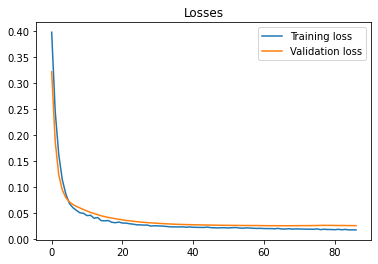

In [ ]:
input_dim = seq_size
output_dim = trainX.shape[2]
hidden_dim = 16
layer_dim = 1
dropout = 0
n_epochs = 1000
learning_rate = 7e-5
weight_decay = 0

model = S4Layer(features=output_dim, lmax=2, N=1024)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

start = dt.now()

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
train_pred, val_pred = opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

testPredict, testValues = opt.evaluate(test_loader, batch_size=1, n_features=input_dim)

In [ ]:
# df_dataset = scaler.inverse_transform(dataset)
df_train = scaler.inverse_transform(train_pred.reshape(-1, 3))
df_val = scaler.inverse_transform(val_pred.reshape(-1, 3))
df_test = scaler.inverse_transform(testPredict.reshape(-1, 3))
dataset = scaler.inverse_transform(dataset)

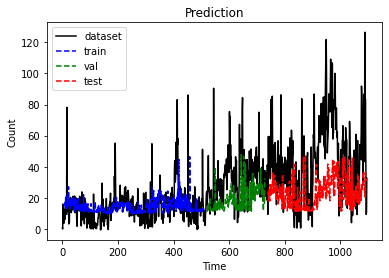

In [ ]:
plotting (dataset[:, 0].reshape(-1, 1), df_train[:, 0].reshape(-1, 1), df_val[:, 0].reshape(-1, 1), df_test[:, 0].reshape(-1, 1)) #plotting without inverse_transform

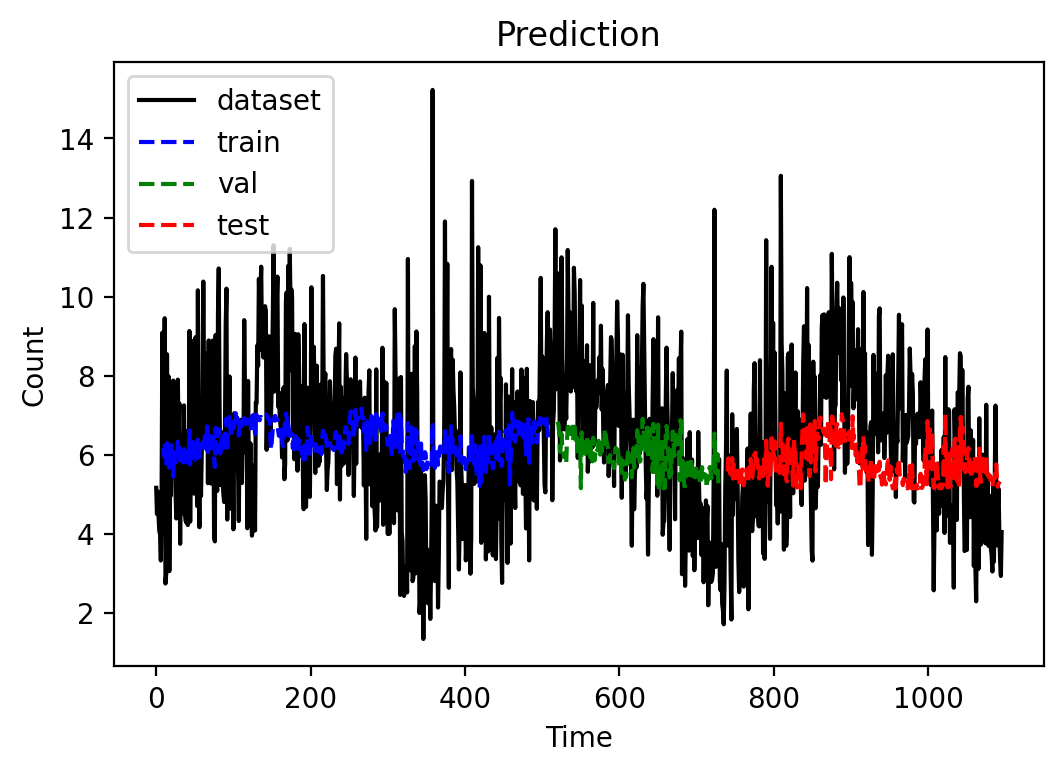

In [ ]:
plotting (dataset[:, -1].reshape(-1, 1), df_train[:, -1].reshape(-1, 1), df_val[:, -1].reshape(-1, 1), df_test[:, -1].reshape(-1, 1)) #plotting without inverse_transform

In [ ]:
np.square(df_test[:, 0] - scaler.inverse_transform(testY)[:, 0]).mean()

1013.0438425712225

In [ ]:
np.abs(df_test[:, 0] - scaler.inverse_transform(testY)[:, 0]).mean()

25.823480377448703

In [ ]:
def mape(x, y):
  error = abs(x-y)/abs(x)
  error[error > 1] = 1
  return np.mean(error)

mape(df_test[:, 0], scaler.inverse_transform(testY)[:, 0])

0.7516595798745832

In [ ]:
np.square(df_test[:, 1] - scaler.inverse_transform(testY)[:, 1]).mean()

1741656924.3608289

In [ ]:
np.abs(df_test[:, 1] - scaler.inverse_transform(testY)[:, 1]).mean()

34469.24461511299

In [ ]:
def mape(x, y):
  error = abs(x-y)/abs(x)
  error[error > 1] = 1
  return np.mean(error)

mape(df_test[:, 1], scaler.inverse_transform(testY)[:, 1])

0.09769348272151332